## 질병 의심 예측 ##
- 주어진 데이터셋으로 질병 의심 예측
- 모델을 통해서가 아닌 정량적인 기준을 토대로 조건문으로 수행

In [5]:
import pandas as pd

# CSV 불러오기
df = pd.read_csv("./data/health_2023_cleaned_final.csv")

cols_to_float = [
    '식전혈당(공복혈당)', '수축기혈압', '이완기혈압',
    '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
    '혈청지오티(AST)', '혈청지피티(ALT)', '감마지티피',
    '혈청크레아티닌', '요단백',
    '신장(5cm단위)', '체중(5kg단위)', '허리둘레'
]

for col in cols_to_float:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# BMI 계산 (체중 kg / (신장 m)^2)
df['BMI'] = (df['체중(5kg단위)'] * 1.0) / ((df['신장(5cm단위)'] / 100) ** 2)

# --------- [1. 당뇨병 의심] ---------
df['당뇨병의심'] = df['식전혈당(공복혈당)'].apply(lambda x: 1 if pd.notna(x) and x >= 126 else 0)

# --------- [2. 고혈압 의심] ---------
df['고혈압의심'] = df.apply(
    lambda row: 1 if (
        pd.notna(row['수축기혈압']) and row['수축기혈압'] >= 140
        or pd.notna(row['이완기혈압']) and row['이완기혈압'] >= 90
    ) else 0,
    axis=1
)

# --------- [3. 고지혈증 / 이상지질혈증 의심] ---------
df['고지혈증의심'] = df.apply(
    lambda row: 1 if (
        (pd.notna(row['총콜레스테롤']) and row['총콜레스테롤'] >= 240)
        or (pd.notna(row['LDL콜레스테롤']) and row['LDL콜레스테롤'] >= 160)
        or (pd.notna(row['HDL콜레스테롤']) and row['HDL콜레스테롤'] < 40)
        or (pd.notna(row['트리글리세라이드']) and row['트리글리세라이드'] >= 200)
    ) else 0,
    axis=1
)

# --------- [4. 간 질환 의심] ---------
df['간질환의심'] = df.apply(
    lambda row: 1 if (
        (pd.notna(row['혈청지오티(AST)']) and row['혈청지오티(AST)'] > 40)
        or (pd.notna(row['혈청지피티(ALT)']) and row['혈청지피티(ALT)'] > 40)
        or (pd.notna(row['감마지티피']) and (
            (row['성별코드'] == 1 and row['감마지티피'] > 63) or
            (row['성별코드'] == 2 and row['감마지티피'] > 35)
        ))
    ) else 0,
    axis=1
)

# --------- [5. 신장 질환 의심] ---------
df['신장질환의심'] = df.apply(
    lambda row: 1 if (
        (pd.notna(row['요단백']) and row['요단백'] >= 3)  # +1 이상
        or (pd.notna(row['혈청크레아티닌']) and row['혈청크레아티닌'] > 1.7)
        or (pd.notna(row['수축기혈압']) and row['수축기혈압'] >= 140)
    ) else 0,
    axis=1
)

# --------- [6. 심혈관질환 위험군] ---------
df['심혈관질환위험'] = df.apply(
    lambda row: 1 if (
        row['고혈압의심'] == 1
        or row['고지혈증의심'] == 1
        or row['당뇨병의심'] == 1
        or (pd.notna(row['BMI']) and row['BMI'] >= 27.5)
        or (pd.notna(row['연령대코드(5세단위)']) and row['연령대코드(5세단위)'] >= 13)
        or (row['흡연상태'] == 3)
        or (row['음주여부'] == 1)
    ) else 0,
    axis=1
)

# --------- [7. 비만 / 대사증후군 의심] ---------
df['비만의심'] = df.apply(
    lambda row: 1 if (
        (pd.notna(row['BMI']) and row['BMI'] >= 25)
        or (pd.notna(row['허리둘레']) and (
            (row['성별코드'] == 1 and row['허리둘레'] >= 90) or
            (row['성별코드'] == 2 and row['허리둘레'] >= 85)
        ))
        or row['고지혈증의심'] == 1
        or row['고혈압의심'] == 1
        or row['당뇨병의심'] == 1
    ) else 0,
    axis=1
)


cols = ['당뇨병의심', '고혈압의심', '고지혈증의심', '간질환의심', '신장질환의심', '심혈관질환위험', '비만의심']
print(df[cols].sum())  # 각 질병군 의심 인원 수 요약


당뇨병의심       29399
고혈압의심       53723
고지혈증의심     102486
간질환의심       82131
신장질환의심      54796
심혈관질환위험    308824
비만의심       211267
dtype: int64


## 비만 예측 모델 ##

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 예측 대상: 비만의심
target = '비만의심'

# 사용할 특성 정의
features = [
    '연령대코드(5세단위)', '성별코드', '허리둘레', '식전혈당(공복혈당)', '수축기혈압', '이완기혈압',
    '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤'
]

# 결측치 제거
ml_df = df[features + [target]].dropna()
X = ml_df[features]
y = ml_df[target]

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 예측 및 평가
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.96      0.91     24382
           1       0.98      0.92      0.95     42159

    accuracy                           0.93     66541
   macro avg       0.92      0.94      0.93     66541
weighted avg       0.94      0.93      0.93     66541



## 테스트 ##

cv=10 교차검증 테스트

정확도: 0.9328
교차검증 (cv=5) 평균 정확도: 0.9329 (std: 0.0007)
교차검증 (cv=5) 평균 정확도: 0.9329 (std: 0.0007)


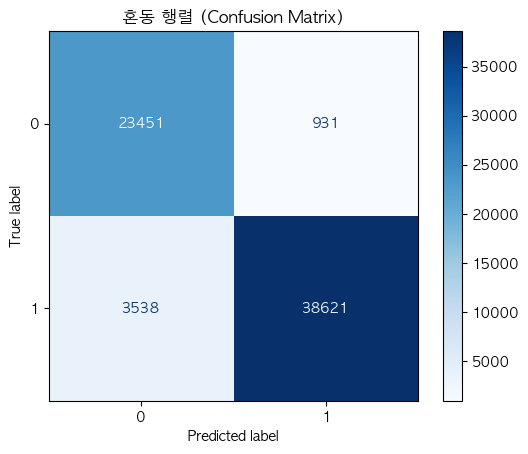

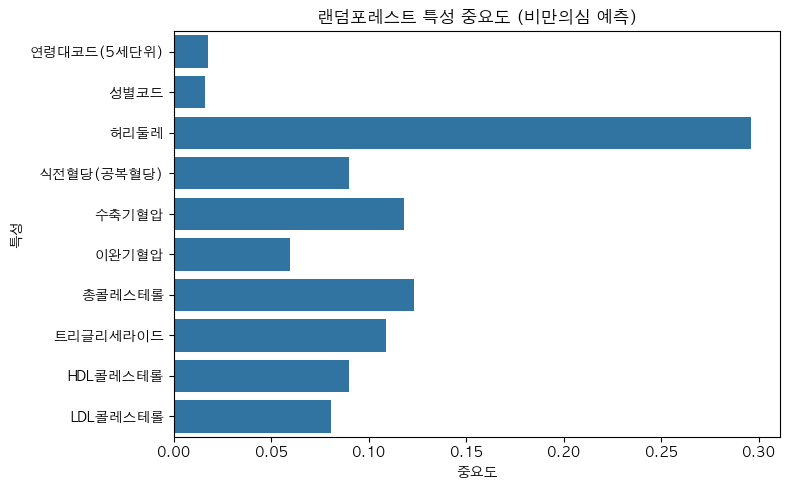

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# macOS 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows용, macOS에서는 주석)
# plt.rcParams['axes.unicode_minus'] = False

# 정확도 출력
acc = accuracy_score(y_test, y_pred)
print(f"정확도: {acc:.4f}")

# 교차검증 (5-겹)
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"교차검증 (cv=5) 평균 정확도: {np.mean(cv_scores):.4f} (std: {np.std(cv_scores):.4f})")

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("혼동 행렬 (Confusion Matrix)")
plt.show()

# 특성 중요도 시각화
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("랜덤포레스트 특성 중요도 (비만의심 예측)")
plt.xlabel("중요도")
plt.ylabel("특성")
plt.tight_layout()
plt.show()

cv=10 교차검증 테스트

정확도: 0.9328
교차검증 (cv=10) 평균 정확도: 0.9326 (std: 0.0015)
교차검증 (cv=10) 평균 정확도: 0.9326 (std: 0.0015)


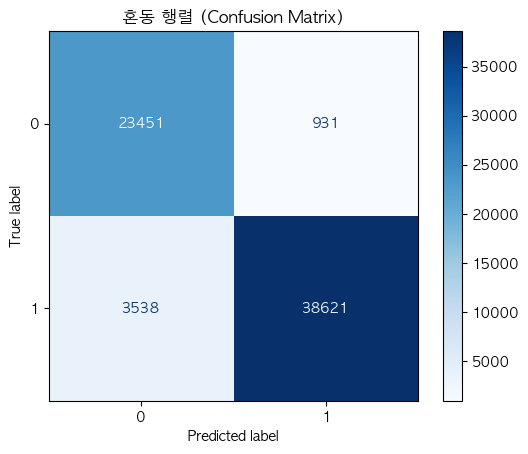

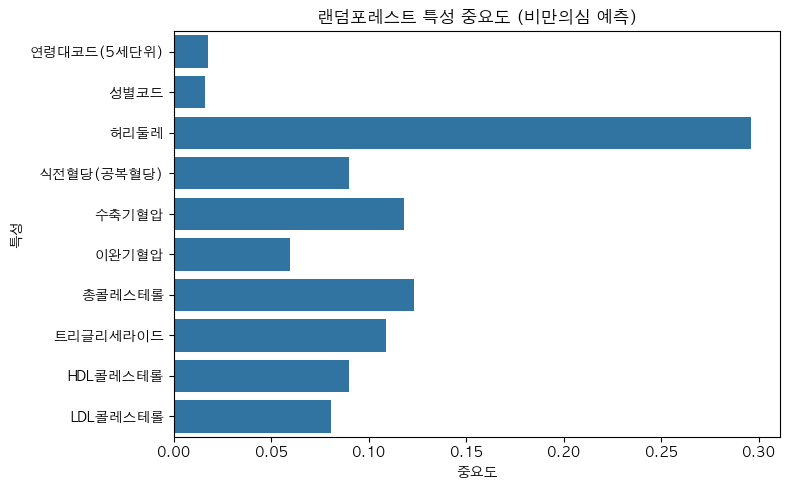

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 정확도 출력
acc = accuracy_score(y_test, y_pred)
print(f"정확도: {acc:.4f}")

# 10-겹 교차검증
cv_scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print(f"교차검증 (cv=10) 평균 정확도: {np.mean(cv_scores):.4f} (std: {np.std(cv_scores):.4f})")

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("혼동 행렬 (Confusion Matrix)")
plt.show()

# 특성 중요도 시각화
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("랜덤포레스트 특성 중요도 (비만의심 예측)")
plt.xlabel("중요도")
plt.ylabel("특성")
plt.tight_layout()
plt.show()
